# Bayesian neural network
In this notebook, we make use of HMC to estimate the posterior predictive distribution of a 1-dimensional regression problem and the rotating MNIST (rMNIST)

In [59]:
import jax
import blackjax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from typing import Callable
from dynamax.utils import datasets
from jaxtyping import Float, Array
from dataclasses import dataclass
from jax.flatten_util import ravel_pytree

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)
key_warmup, key_train = jax.random.split(key_train)

# 1D-regression

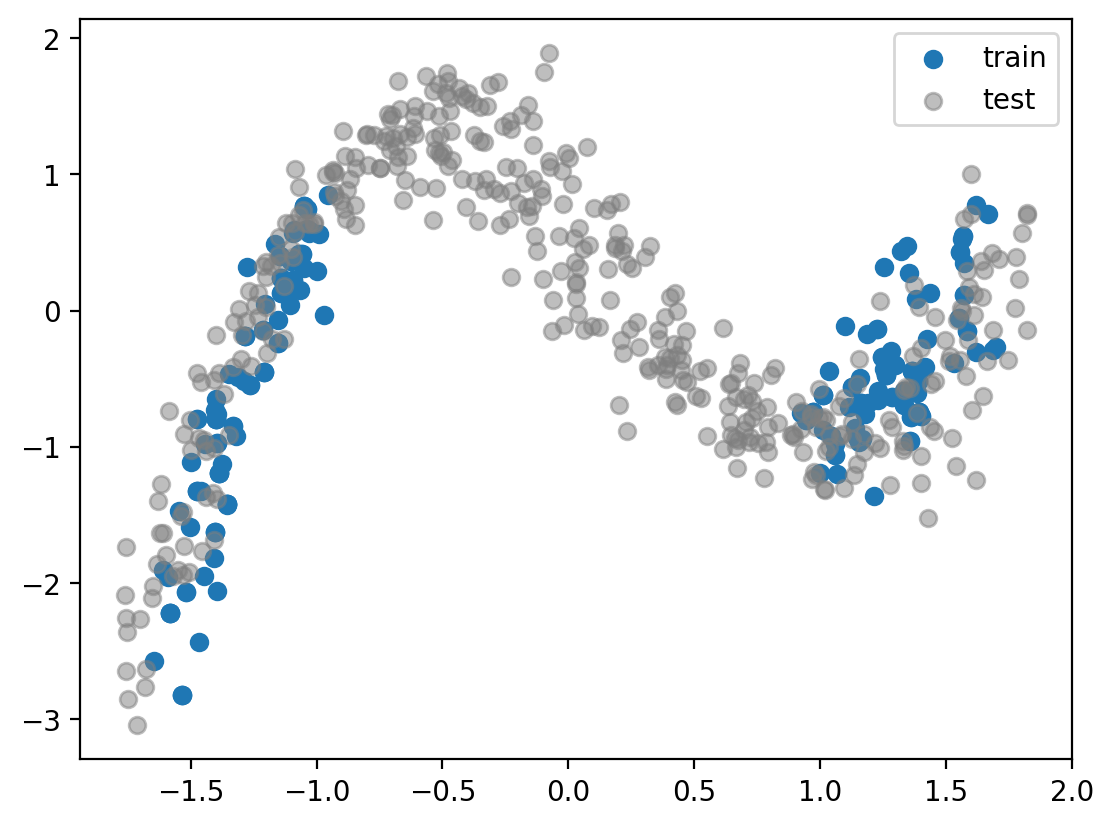

In [76]:
train, test = datasets.load_1d_synthetic_dataset(200, 400, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, c="tab:gray", label="test", alpha=0.5, )
plt.legend()

## Model setup

In [77]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

In [78]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float


def get_leaves(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params


def log_joint(
    params: nn.FrozenDict,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam,
):
    """
    TODO:
    * Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    params_flat = get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    
    logprob = logp_prior + logp_obs
    return logprob


In [79]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


In [80]:
dim_input = 1
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=200, activation=nn.elu)
batch = jnp.ones(batch)

In [81]:
params_init = model.init(key_init, batch)
_, reconstruct_fn = ravel_pytree(params_init)

In [137]:
%%time
num_eval = [1, 5, 10, 20, 50, 100, 150, 200]
num_eval = list(range(2, 202, 2))

num_warmup = 200
num_steps = 100
priors = PriorParam(scale_obs=2.0, scale_weight=0.5)
    
params_hist = {}
for neval in tqdm(num_eval):
    X_eval = X_train[:neval]
    y_eval = y_train[:neval]
    # Sample initial parameters
    potential = partial(log_joint,
                        priors=priors, X=X_eval, y=y_eval,
                        reconstruct_fn=reconstruct_fn, model=model)

    adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
    final_state, kernel, _ = adapt.run(key_warmup, params_init)
    states = inference_loop(key_train, kernel, final_state, num_steps)

    sampled_params = jax.block_until_ready(states.position)
    params_hist[neval] = sampled_params

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 28min 59s, sys: 38.8 s, total: 29min 38s
Wall time: 38min 6s


In [ ]:
%%time
num_warmup = 200
num_steps = 100


X_eval = X_train[:200]
y_eval = y_train[:200]
# Sample initial parameters
priors = PriorParam(scale_obs=2.0, scale_weight=0.5)
potential = partial(log_joint,
                    priors=priors, X=X_eval, y=y_eval,
                    reconstruct_fn=reconstruct_fn, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params_init)
states = inference_loop(key_train, kernel, final_state, num_steps)

sampled_params = jax.block_until_ready(states.position)

In [139]:
def plot_posterior_predictive(params, evalfn, xrange):
    yhat_samples = jax.vmap(evalfn, (0, None))(params, xrange).squeeze()
    
    yhat_mean = yhat_samples.mean(axis=0)
    yhat_std = yhat_samples.std(axis=0)
    
    plt.plot(xrange, yhat_mean, c="tab:blue", linewidth=2, label="mean pp")
    plt.plot(xrange, yhat_mean + 2 * yhat_std, c="tab:gray", linewidth=1)
    plt.plot(xrange, yhat_mean - 2 * yhat_std, c="tab:gray", linewidth=1)

    for sample in yhat_samples:
        plt.plot(xrange, sample, c="tab:gray", alpha=0.05)

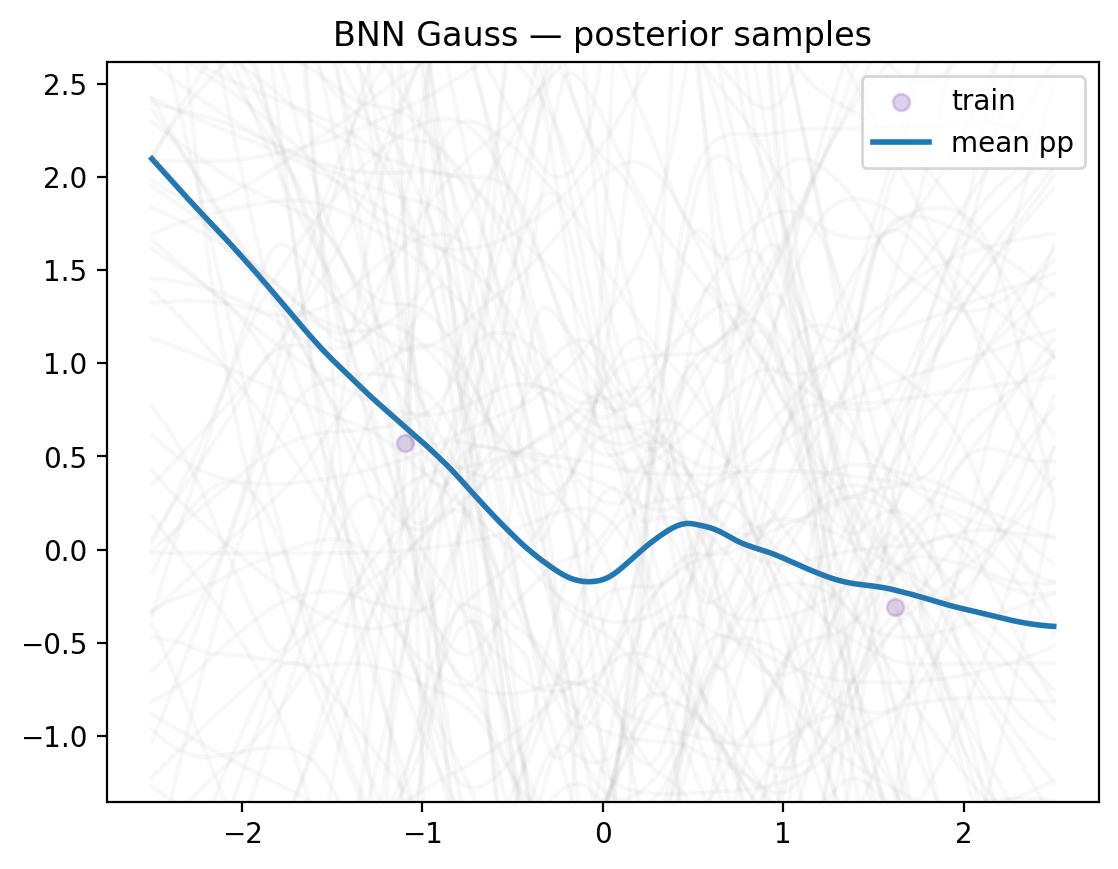

In [142]:
fig, ax = plt.subplots()

def animate_ppd(n):
    ax.cla()
    n_eval = num_eval[n]
    X_eval = X_train[:n_eval]
    y_eval = y_train[:n_eval]

    plt.scatter(X_eval, y_eval, alpha=0.3, c="tab:purple", label="train")
    ymin, ymax = plt.ylim()
    plot_posterior_predictive(params_hist[n_eval], model.apply, x_eval[:, None])
    plt.ylim(ymin - 1.0, ymax + 2.0)
    plt.legend()
    plt.title("BNN Gauss — posterior samples");
    
    return ax

frames = list(range(len(params_hist)))
anim1 = animation.FuncAnimation(fig, animate_ppd, frames=frames)
anim1.save("animation-hmc.mp4", dpi=100, bitrate=-1, fps=10)

## Evaluation metrics

In [ ]:
sampled_params = params_hist[200]
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()

### Mean absolute error

In [155]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(0.32022235, dtype=float32)

### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [176]:
means = yhat_samples.mean(axis=0).sum()
nll = -distrax.Normal(means, priors.scale_obs).log_prob(y_test).mean()
nll

Array(7.658239, dtype=float32)

# Rotating MNIST

In [182]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, dim_input = X_train.shape

In [183]:
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=200, activation=nn.elu)
batch = jnp.ones(batch)

In [184]:
params_init = model.init(key_init, batch)
_, reconstruct_fn = ravel_pytree(params_init)

In [227]:
%%time
num_eval = 100
num_warmup = 200
num_steps = 100

X_eval = X_train[:num_eval]
y_eval = y_train[:num_eval]
# Sample initial parameters
priors = PriorParam(scale_obs=2.0, scale_weight=1/2)
potential = partial(log_joint,
                    priors=priors, X=X_eval, y=y_eval,
                    reconstruct_fn=reconstruct_fn, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params_init)
states = inference_loop(key_train, kernel, final_state, num_steps)

sampled_params = jax.block_until_ready(states.position)

CPU times: user 20.8 s, sys: 436 ms, total: 21.3 s
Wall time: 1min 20s


## Evaluation metrics

In [228]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()
yhat_train_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_train).squeeze()

### Mean absolute error

In [233]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(19.99278, dtype=float32)

In [234]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(27.813221, dtype=float32)

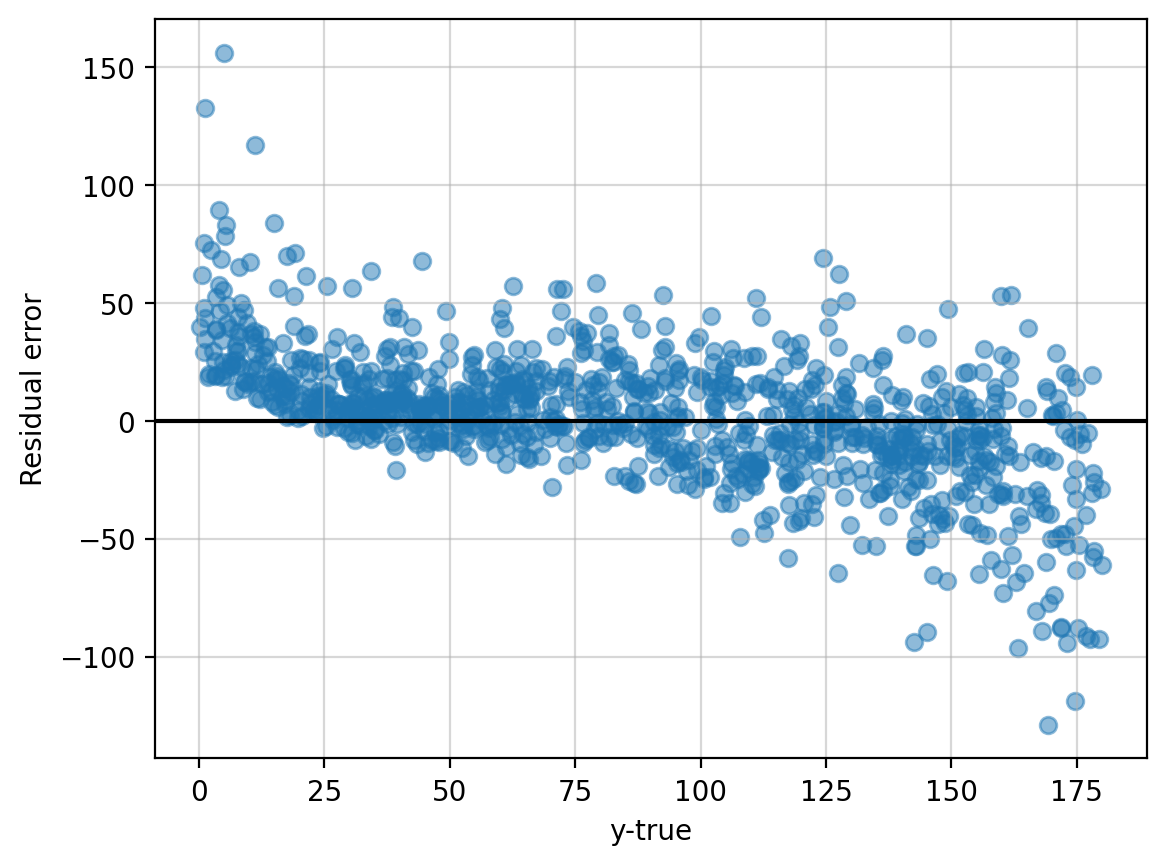

In [235]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [243]:
import pandas as pd

In [236]:
means = yhat_samples.mean(axis=0).sum()
nll = -distrax.Normal(means, priors.scale_obs).log_prob(y_test).mean()
nll

Array(1.0651543e+09, dtype=float32)

## Evaluating increasing number of datapoints

In [242]:
%%time
num_eval = list(range(2, 102, 2))

num_warmup = 200
num_steps = 100
priors = PriorParam(scale_obs=2.0, scale_weight=1/2)

vapply = jax.vmap(model.apply, (0, None))

hist = []
for neval in (pbar := tqdm(num_eval)):
    X_eval = X_train[:neval]
    y_eval = y_train[:neval]
    # Sample initial parameters
    potential = partial(log_joint,
                        priors=priors, X=X_eval, y=y_eval,
                        reconstruct_fn=reconstruct_fn, model=model)

    adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
    final_state, kernel, _ = adapt.run(key_warmup, params_init)
    states = inference_loop(key_train, kernel, final_state, num_steps)

    sampled_params = jax.block_until_ready(states.position)
    
    yhat_samples = vapply(sampled_params, X_test).squeeze()
    yhat_train_samples = vapply(sampled_params, X_eval).squeeze()
    
    
    yhat_test = yhat_samples.mean(axis=0)
    yhat_eval = yhat_train_samples.mean(axis=0)
    
    metric_mae = jnp.abs(yhat_test - y_test).mean()
    metric_mae_train = jnp.abs(yhat_eval - y_eval).mean()
    
    metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
    metric_rmse_train = jnp.sqrt(jnp.power(yhat_eval - y_eval, 2).mean())
    
    
    entry = {
        "mae_test": metric_mae.item(),
        "mae_train": metric_mae_train.item(),
        "rmse_test": metric_rmse.item(),
        "rmse_train": metric_rmse_train.item(),
        "num_points": neval
        
    }
    
    progress = f"X(:{neval}) MAE test -- {metric_mae.item():0.3f} | MAE train -- {metric_mae_train.item():0.3f}"
    print(progress)
    
    hist.append(entry)

  0%|          | 0/50 [00:00<?, ?it/s]

X(:2) MAE test -- 45.078 | MAE train -- 0.186
X(:4) MAE test -- 35.958 | MAE train -- 0.150
X(:6) MAE test -- 38.300 | MAE train -- 0.383
X(:8) MAE test -- 39.987 | MAE train -- 0.101
X(:10) MAE test -- 39.895 | MAE train -- 0.108
X(:12) MAE test -- 37.823 | MAE train -- 0.159
X(:14) MAE test -- 35.361 | MAE train -- 0.141
X(:16) MAE test -- 36.626 | MAE train -- 0.132
X(:18) MAE test -- 35.749 | MAE train -- 0.154
X(:20) MAE test -- 36.661 | MAE train -- 0.178
X(:22) MAE test -- 36.917 | MAE train -- 0.106
X(:24) MAE test -- 34.775 | MAE train -- 0.178
X(:26) MAE test -- 34.500 | MAE train -- 0.207
X(:28) MAE test -- 31.949 | MAE train -- 0.374
X(:30) MAE test -- 28.134 | MAE train -- 0.171
X(:32) MAE test -- 31.329 | MAE train -- 0.394
X(:34) MAE test -- 28.159 | MAE train -- 0.327
X(:36) MAE test -- 25.923 | MAE train -- 0.186
X(:38) MAE test -- 27.994 | MAE train -- 0.303
X(:40) MAE test -- 26.409 | MAE train -- 0.272
X(:42) MAE test -- 25.195 | MAE train -- 0.194
X(:44) MAE test -

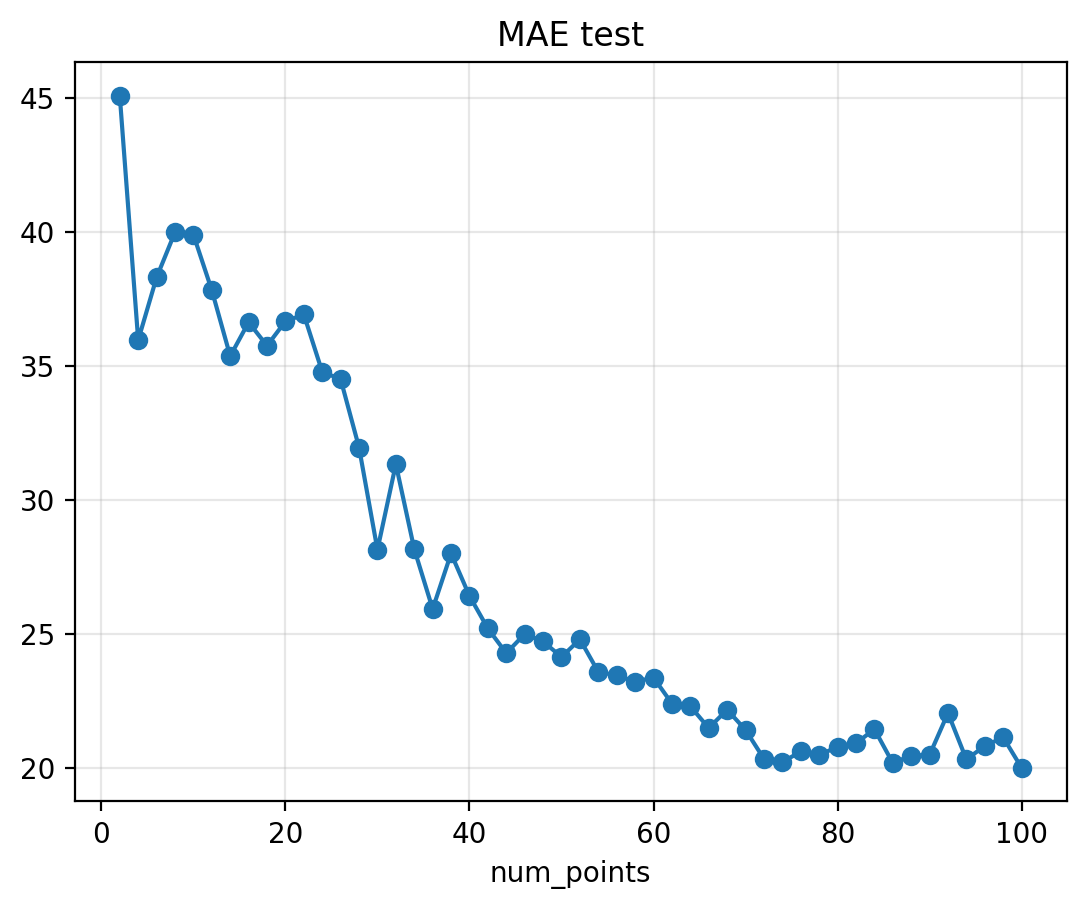

In [253]:
df_hist = pd.DataFrame(hist).set_index("num_points")
df_hist["mae_test"].plot(marker="o")
plt.title("MAE test")
plt.grid(alpha=0.3)